## Load the tmdb movies dataset and explore the data first

In [2]:
import json
import pandas as pd

In [3]:
def load_movies(path):
    data_file = pd.read_csv(path)
    data_file['release_date'] = pd.to_datetime(data_file['release_date']).apply(lambda x: x.date())
    columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in columns:
        data_file[column] = data_file[column].apply(json.loads)
    return data_file

def load_credits(path):
    data_file = pd.read_csv(path)
    columns = ['cast', 'crew']
    for column in columns:
       data_file[column] = data_file[column].apply(json.loads)
    return data_file

In [4]:
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
            
        return result
    
    except IndexError or KeyError:
        return pd.np.nan



def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies['year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(lambda x: '|'.join([i['name'] for i in x]))
    tmdb_movies['keywords'] = tmdb_movies['keywords'].apply(lambda x: '|'.join([i['name'] for i in x]))
    tmdb_movies['director'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    return tmdb_movies

In [5]:
import sys  

!{sys.executable} -m pip install scikit-learn


In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math, nltk
from nltk.corpus import wordnet
from sklearn.neighbors import NearestNeighbors

PS = nltk.stem.PorterStemmer()
credits = load_credits("./tmdb_5000_credits.csv")
movies = load_movies("./tmdb_5000_movies.csv")
data_initial = convert_to_original_format(movies, credits)
print('Shape:',data_initial.shape)
tab_info=pd.DataFrame(data_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(data_initial.isnull().sum()/data_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 27)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,year,country,language,director,actor_1,actor_2,actor_3
column type,int64,object,object,int64,object,object,object,object,float64,object,...,object,float64,int64,float64,object,object,object,object,object,object
null values,0,0,3091,0,0,0,0,3,0,0,...,0,0,0,1,174,86,30,53,63,93
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,...,0,0,0,0.0208203,3.62274,1.79055,0.62461,1.10348,1.31168,1.93629


In [8]:
tab_info.describe()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,year,country,language,director,actor_1,actor_2,actor_3
count,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
unique,2,2,3,2,2,2,2,3,2,2,...,2,2,2,3,3,3,3,3,3,3
top,0,0,object,0,0,0,0,object,0,0,...,0,0,0,float64,object,object,object,object,object,object
freq,2,2,1,2,2,2,2,1,2,2,...,2,2,2,1,1,1,1,1,1,1


In [9]:
data_initial.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,year
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4802.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,2002.468763
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,12.414354
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1916.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,1999.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,2005.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,2011.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000


In [10]:
data_initial[['title', 'genres', 'year', 'vote_average', 'director', 'actor_1', 'actor_2', 'actor_3']].head(10)

,title,genres,year,vote_average,director,actor_1,actor_2,actor_3
0,Avatar,Action|Adventure|Fantasy|Science Fiction,2009.0,7.2,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,Pirates of the Caribbean: At World's End,Adventure|Fantasy|Action,2007.0,6.9,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,Spectre,Action|Adventure|Crime,2015.0,6.3,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,The Dark Knight Rises,Action|Crime|Drama|Thriller,2012.0,7.6,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,John Carter,Action|Adventure|Science Fiction,2012.0,6.1,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,Spider-Man 3,Fantasy|Action|Adventure,2007.0,5.9,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,Tangled,Animation|Family,2010.0,7.4,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,Avengers: Age of Ultron,Action|Adventure|Science Fiction,2015.0,7.3,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,Harry Potter and the Half-Blood Prince,Adventure|Fantasy|Family,2009.0,7.4,David Yates,Rupert Grint,Emma Watson,Tom Felton
9,Batman v Superman: Dawn of Justice,Action|Adventure|Fantasy,2016.0,5.7,Zack Snyder,Henry Cavill,Gal Gadot,Amy Adams


## keywords search

As a movie recommendation system, it allows users to input some keywords and the system provides some recommendations. Films described by similar keywords should have similar contents. Therefore, keywords play as an important factor in our system. Firstly, list the keywords which are in the dataset:

In [11]:
set_keywords = set()
for keyword in data_initial['keywords'].str.split('|').values:
    if isinstance(keyword, float): continue 
    set_keywords = set_keywords.union(keyword)

In [12]:
def count_word(df, col, lis):
    count = dict()
    for s in lis: count[s] = 0
    for keywords in df[col].str.split('|'):
        if type(keywords) == float and pd.isnull(keywords): continue
        for s in [s for s in keywords if s in lis]:
            if pd.notnull(s): count[s] += 1
    occurences = []
    for k,v in count.items():
        occurences.append([k,v])
    occurences.sort(key = lambda x:x[1], reverse = True)
    return occurences, count

In [13]:
occurences, keyword_count = count_word(data_initial, 'keywords', set_keywords)
occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [14]:
occurences = [x for x in occurences if x[0]]

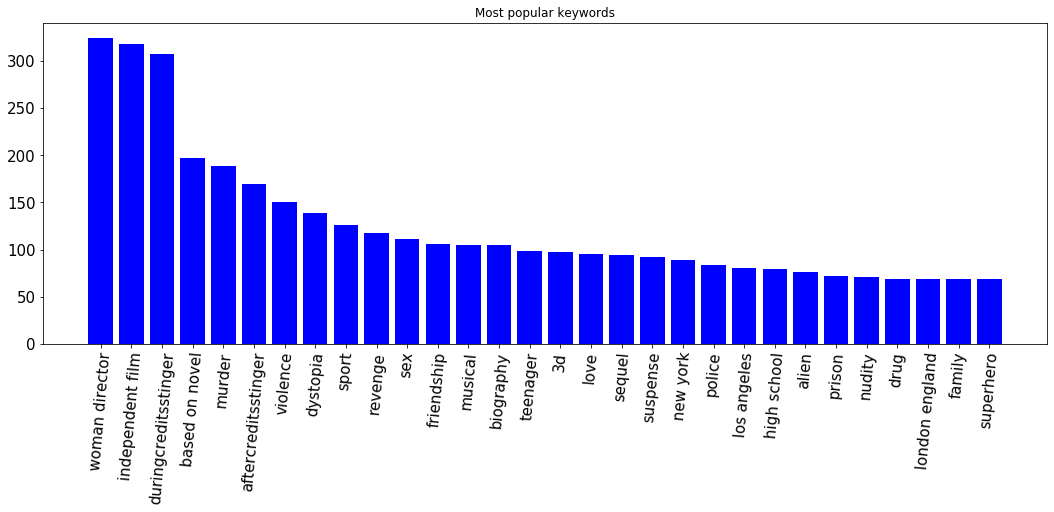

In [15]:
fig = plt.figure(1, figsize=(18,13))
plot = fig.add_subplot(2,1,2)
tmp = occurences[0:30]
y_axis = [i[1] for i in tmp]
x_axis = [k for k,i in enumerate(tmp)]
x_label = [i[0] for i in tmp]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.title('Most popular keywords')
plot.bar(x_axis, y_axis, color='blue')
plt.show()

As in every analysis, we will have to deal with the missing values

In [16]:
missing_data = data_initial.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data['filling_factor'] = (data_initial.shape[0] 
                                - missing_data['missing_count']) / data_initial.shape[0] * 100
missing_data.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3,93,98.063710
4,language,86,98.209452
5,actor_2,63,98.688320
6,actor_1,53,98.896523
7,director,30,99.375390
8,overview,3,99.937539
9,runtime,2,99.958359


Based on the result above, I found that only 2 of them have a filling factor below 90%.

## Number of films per decade

Group the films by decades and show in a pie chart.

In [17]:
data_initial['decade'] = data_initial['year'].apply(lambda x:((x-1900)//10)*10)
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
test = data_initial['year'].groupby(data_initial['decade']).apply(get_stats).unstack()

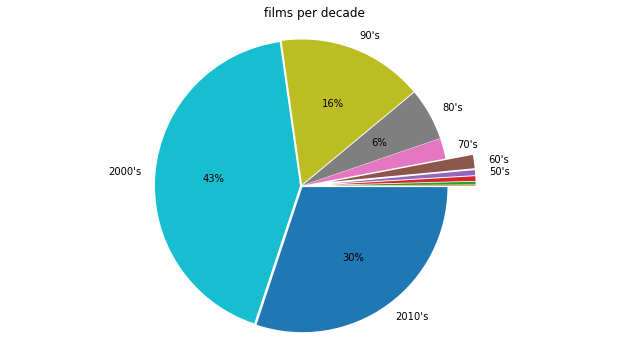

In [18]:
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 3 else '')
ax.axis('equal')
ax.set_title('films per decade');
data_initial.drop('decade', axis=1, inplace = True)

## Genres

I want to explore genres. Firstly, list the genres which are in the dataset

In [19]:
genre_labels = set()
for s in data_initial['genres'].str.split(',').values:
    genre_labels = genre_labels.union(set(s))

In [20]:
occurences, dum = count_word(data_initial, 'genres', genre_labels)
occurences = [x for x in occurences if x[0]]
occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

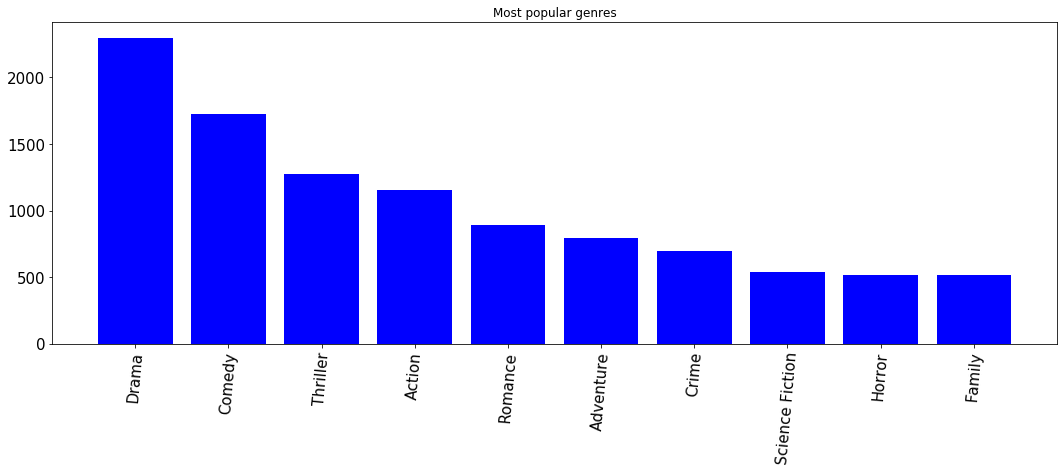

In [21]:
fig = plt.figure(1, figsize=(18,13))
plot = fig.add_subplot(2,1,2)
tmp = occurences[0:10]
y_axis = [i[1] for i in tmp]
x_axis = [k for k,i in enumerate(tmp)]
x_label = [i[0] for i in tmp]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plot.bar(x_axis, y_axis, color='blue')
plt.title('Most popular genres')
plt.show()

## Dealing with duplicates

In [22]:
dup_entries = data_initial[data_initial.id.duplicated()]
dup_entries.shape

(0, 27)

In [23]:
data_temp = data_initial
list_dups = data_temp['title'].map(data_temp['title'].value_counts() > 1)

In [24]:

#Show the movies with same title and the director of these movies.
data_temp[list_dups][['title', 'director', 'year']].sort_values('title')

,title,director,year
1359,Batman,Tim Burton,1989.0
4267,Batman,Leslie H. Martinson,1966.0
3647,Out of the Blue,Dennis Hopper,1980.0
3693,Out of the Blue,Robert Sarkies,2006.0
972,The Host,Andrew Niccol,2013.0
2877,The Host,Bong Joon-ho,2006.0


In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn import svm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets


In [50]:
data_initial

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,year,country,language,director,actor_1,actor_2,actor_3
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Avatar,7.2,11800,2009.0,United States of America,English,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,English,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,Spectre,6.3,4466,2015.0,United Kingdom,Français,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,The Dark Knight Rises,7.6,9106,2012.0,United States of America,English,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,John Carter,6.1,2124,2012.0,United States of America,English,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,Spider-Man 3,5.9,3576,2007.0,United States of America,English,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,Tangled,7.4,3330,2010.0,United States of America,English,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...",...,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,English,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,English,David Yates,Rupert Grint,Emma Watson,Tom Felton
9,250000000,Action|Adventure|Fantasy,http://www.batmanvsupermandawnofjustice.com/,209112,dc comics|vigilante|superhero|based on comic b...,en,Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super 

Data selection: 1. As in our data analysis, we can see the movie data collected before and after 2010 have relatively equal amount, so we decided to use past(<2010) to predict for future(>2010)

2. As in our genres analysis, we can see the drama movie has the most amount of data which shows its popularity, we will study futher by developing a regression model only of drama movies and compare with the all movie regression results

In [101]:
train_set = data_initial[data_initial.year < 2010]
test_set = data_initial[data_initial.year >= 2010]
for col in train_set.columns: 
    print(col) 

budget
genres
homepage
id
keywords
original_language
original_title
overview
popularity
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
vote_average
vote_count
year
country
language
director
actor_1
actor_2
actor_3


# Liner regression of Revenue on Budget,release_date,runtime,vote_count and year

In [100]:
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

feature_cols = ['budget',
'release_date',
 'runtime',
'vote_count',
'vote_average'
]
x_train = train_set.loc[:, [column_name for column_name in feature_cols]].values
y_train = train_set.revenue
x_test = test_set.loc[:, [column_name for column_name in feature_cols]].values
y_test = test_set.revenue

# label encoder to transform our data   
le = LabelEncoder()
for i in range(len(feature_cols)):
    x_train[:,i] = le.fit_transform(x_train[:,i])
for i in range(len(feature_cols)):
    x_test[:,i] = le.fit_transform(x_test[:,i])
    
lm = LinearRegression(normalize=True)
lm.fit(x_train,y_train)


y_pred = lm.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


# The coefficients
print ("Coefficient", lm.coef_)
# The intercepts
print ("Intercept: ", lm.intercept_)
# mean square error
print ("Mean Square Error: ", np.mean((lm.predict(x_test) - y_test) ** 2))
print ("Variance Score: ", lm.score(x_test, y_test))
# we have a 0.35 r2 score
print ("R2 Score is:", r2)


Coefficient [  140682.14470851     2289.74459353   775034.80071044   268278.99289734
 -1562024.79072582]
Intercept:  -15773714.691070095
Mean Square Error:  2.5535886670646824e+16
Variance Score:  0.3523001126835744
R2 Score is: 0.3523001126835744


# regression of revenue prediction of drama movies

In [98]:
train_set2 = train_set[train_set.genres.str.contains("Drama")]
test_set2 = test_set[test_set.genres.str.contains("Drama")]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,year,country,language,director,actor_1,actor_2,actor_3
24,207000000,Adventure|Drama|Action,NaN,254,film business|screenplay|show business|film ma...,en,King Kong,"In 1933 New York, an overly ambitious movie pr...",61.226010,"[{'name': 'WingNut Films', 'id': 11}, {'name':...",...,King Kong,6.6,2337,2005.0,New Zealand,English,Peter Jackson,Jack Black,Adrien Brody,Thomas Kretschmann
25,200000000,Drama|Romance|Thriller,http://www.titanicmovie.com,597,shipwreck|iceberg|ship|panic|titanic|ocean lin...,en,Titanic,"84 years later, a 101-year-old woman named Ros...",100.025899,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,Titanic,7.5,7562,1997.0,United States of America,English,James Cameron,Leonardo DiCaprio,Frances Fisher,Billy Zane
60,200000000,Animation|Drama,http://disney.go.com/disneypictures/achristmas...,17979,holiday|based on novel|victorian england|money...,en,A Christmas Carol,Miser Ebenezer Scrooge is awakened on Christma...,39.744242,"[{'name': 'Walt Disney', 'id': 5888}, {'name':...",...,A Christmas Carol,6.6,1095,2009.0,United States of America,English,Robert Zemeckis,Jim Carrey,Steve Valentine,Daryl Sabara
65,185000000,Drama|Action|Crime|Thriller,http://thedarkknight.warnerbros.com/dvdsite/,155,dc comics|crime fighter|secret identity|scarec...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...",...,The Dark Knight,8.2,12002,2008.0,United Kingdom,English,Christopher Nolan,Heath Ledger,Aaron Eckhart,Michael Caine
100,150000000,Fantasy|Drama|Thriller|Mystery|Romance,http://www.benjaminbutton.com/,4922,diary|navy|funeral|tea|travel|hospital,en,The Curious Case of Benjamin Button,"Tells the story of Benjamin Button, a man who ...",60.269279,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,The Curious Case of Benjamin Button,7.3,3292,2008.0,United States of America,English,David Fincher,Brad Pitt,Tilda Swinton,Julia Ormond
104,160000000,Adventure|Action|Drama|Thriller,http://www2.warnerbros.com/poseidon/,503,new year's eve|fire|drowning|cataclysm|loss of...,en,Poseidon,A packed cruise ship traveling the Atlantic is...,21.133748,"[{'name': 'Virtual Studios', 'id': 449}, {'nam...",...,Poseidon,5.5,583,2006.0,United States of America,English,Wolfgang Petersen,Richard Dreyfuss,Josh Lucas,Jacinda Barrett
112,155000000,War|History|Action|Adventure|Drama|Romance,NaN,1966,aristotle|egypt|greece|persia|elephant|campaig...,en,Alexander,"Alexander, the King of Macedonia, leads his le...",39.019229,"[{'name': 'France 3 Cinéma', 'id': 591}, {'nam...",...,Alexander,5.6,927,2004.0,France,English,Oliver Stone,Angelina Jolie,Val Kilmer,Jared Leto
116,150000000,Drama|Horror|Action|Thriller|Science Fiction,http://iamlegend.warnerbros.com/,6479,saving the world|lost civilisation|post-apocal...,en,I Am Legend,Robert Neville is a scientist who was unable t...,70.867401,"[{'name': 'Village Roadshow Pictures', 'id': 7...",...,I Am Legend,6.9,4853,2007.0,United States of America,English,Francis Lawrence,Alice Braga,Charlie Tahan,Salli Richardson-Whitfield
119,150000000,Action|Crime|Drama,http://www2.warnerbros.com/batmanbegins/index....,272,himalaya|martial arts|dc comics|crime fighter|...,en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...",...,Batman Begins,7.5,7359,2005.0,United Kingdom,English,Christopher Nolan,Michael Caine,Liam Neeson,Katie Holmes
145,175000000,Adventure|Drama|War,NaN,652,brother brother relationship|adultery|mytholog...,en,Troy,"In year 1250 B.C. during the late Bronze age, ...",66.803149,"[{'name': 'Plan B Entertainment', 'id': 81}, {...",...,Troy,6.9,2759,2004.0,United States of America,English,Wolfgang Petersen,Orlando Bloom,Eric Bana,Brian Cox


In [99]:
feature_cols = ['budget',
'release_date',
 'runtime',
'vote_count',
'vote_average'
]
x_train = train_set2.loc[:, [column_name for column_name in feature_cols]].values
y_train = train_set2.revenue
x_test = test_set2.loc[:, [column_name for column_name in feature_cols]].values
y_test = test_set2.revenue

# label encoder to transforme the data    
le = LabelEncoder()
for i in range(len(feature_cols)):
    x_train[:,i] = le.fit_transform(x_train[:,i])
for i in range(len(feature_cols)):
    x_test[:,i] = le.fit_transform(x_test[:,i])
    
lm = LinearRegression(normalize=True)
lm.fit(x_train,y_train)
y_pred = lm.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


# The coefficients
print ("Coefficient", lm.coef_)
# The intecept
print ("Intercept: ", lm.intercept_)
# lower mean squared error than first model
print ("Mean Square Error: ", np.mean((lm.predict(x_test) - y_test) ** 2))
print ("Variance Score: ", lm.score(x_test, y_test))
# we have a 0.3 r2 score
print ("R2 Score is:", r2)


Coefficient [  166008.34217393   -10344.49772209   470666.89483907   288108.14564433
 -1346243.29103771]
Intercept:  2839323.7121284977
Mean Square Error:  1.0998356300853142e+16
Variance Score:  0.30324713615510035
R2 Score is: 0.30324713615510035
